Optimization Level 0
Depth: 163
Gate counts: OrderedDict([('cx', 102), ('u1', 98), ('u2', 24), ('ry', 14), ('u3', 14), ('rx', 10)])

Optimization Level 1
Depth: 145
Gate counts: OrderedDict([('cx', 96), ('u1', 73), ('u2', 16), ('u3', 15), ('ry', 7), ('rx', 4)])

Optimization Level 2
Depth: 145
Gate counts: OrderedDict([('cx', 96), ('u1', 65), ('u2', 16), ('u3', 15), ('ry', 7), ('rx', 4)])

Optimization Level 3
Depth: 145
Gate counts: OrderedDict([('cx', 94), ('u1', 65), ('u3', 18), ('u2', 17), ('ry', 7)])



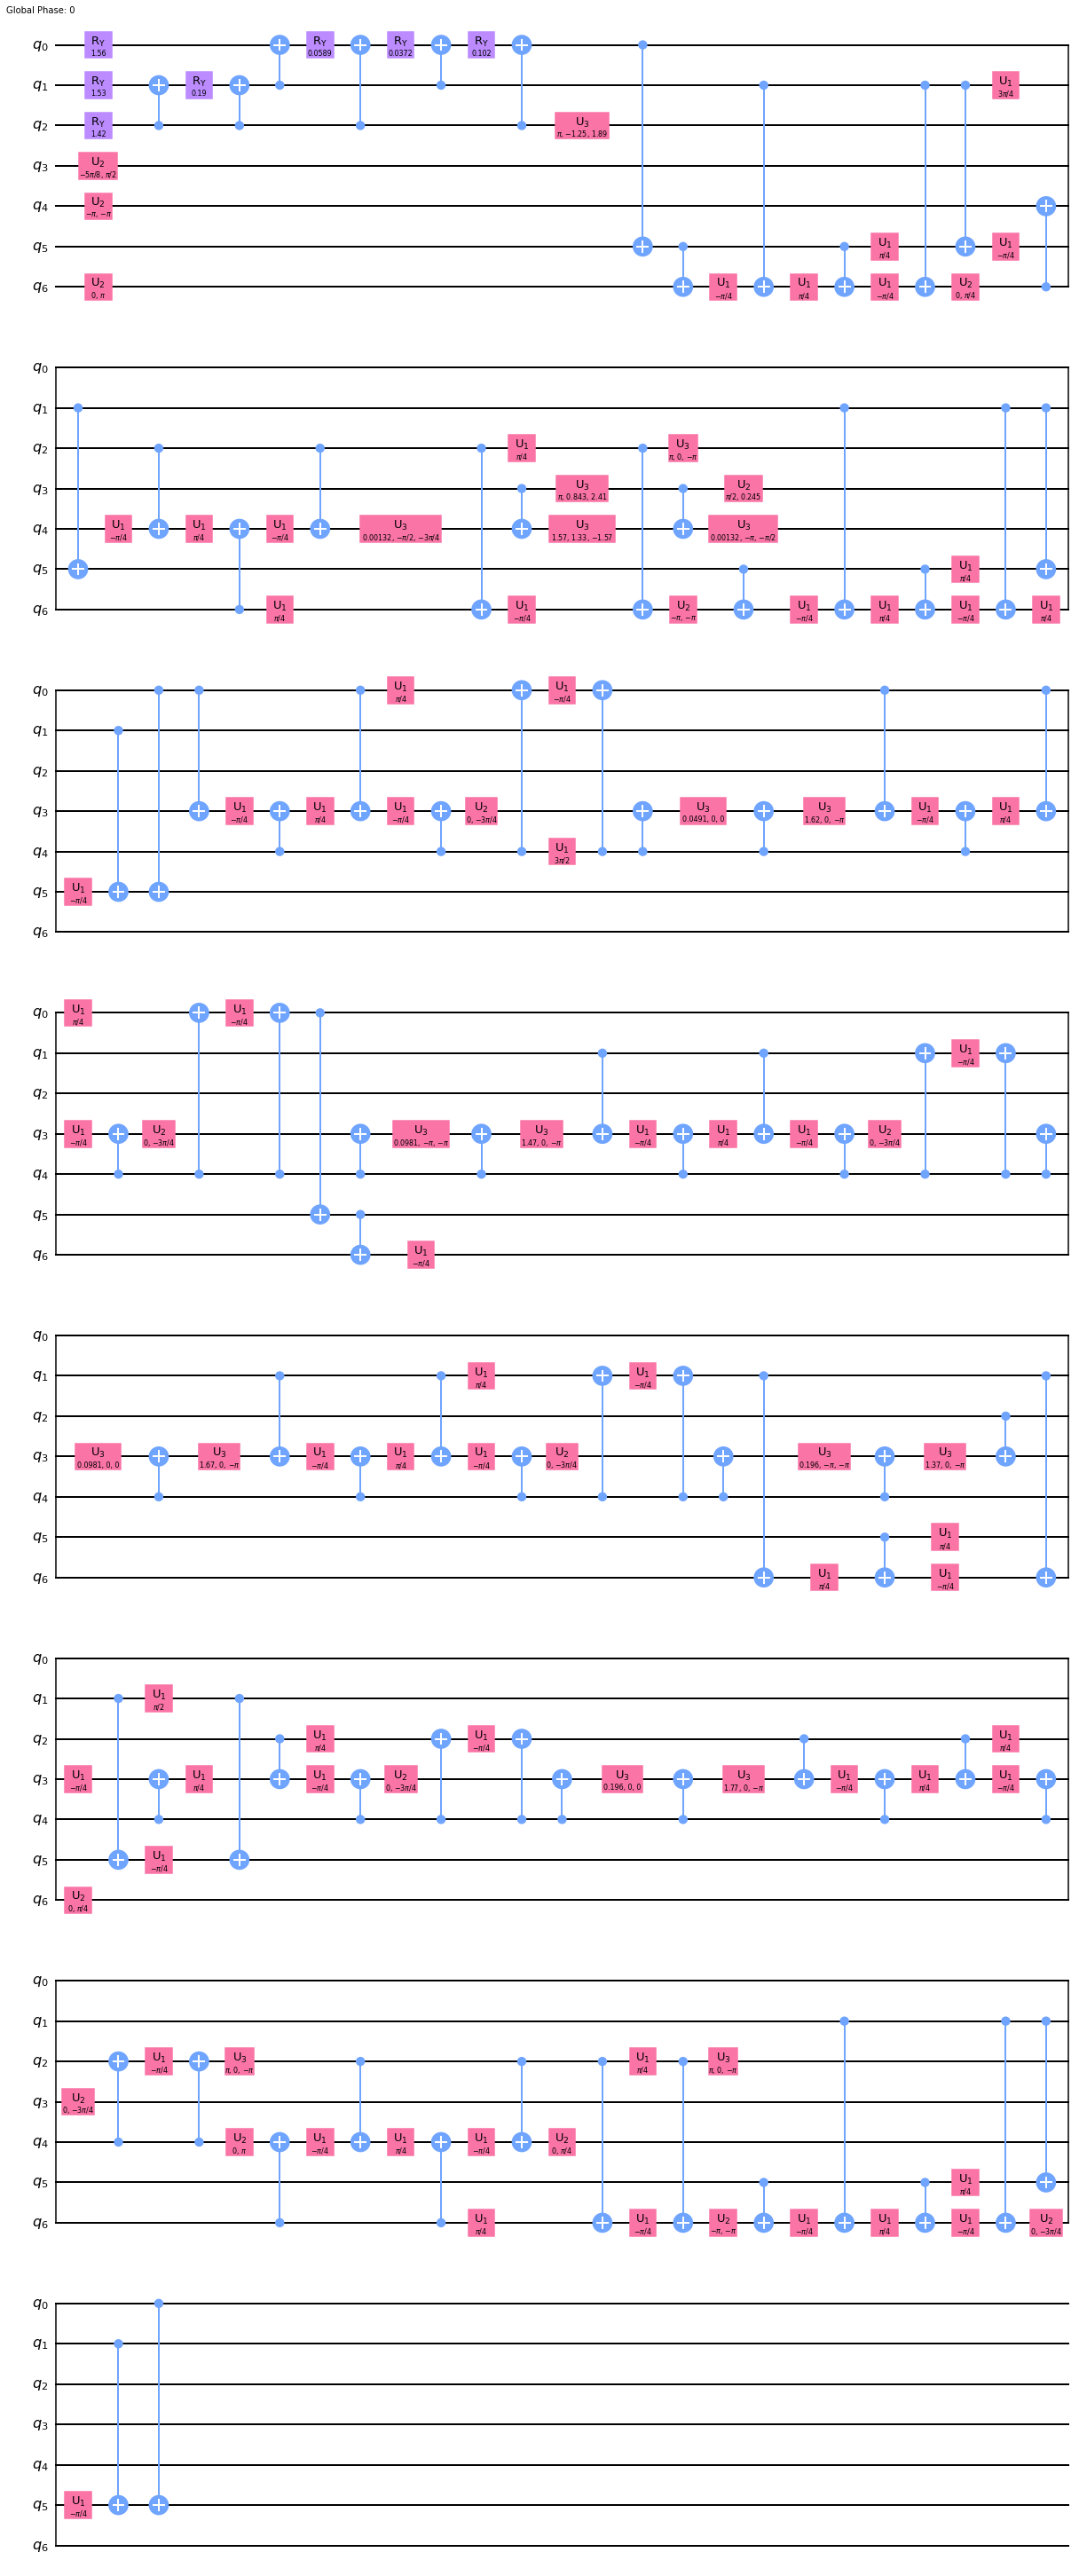

In [1]:
#First we import all the required libraries
import numpy as np
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_finance.circuit.library import LogNormalDistribution

# define uncertainty model
num_uncertainty_qubits = 3
mu=0.68986
sigma=0.132417
strike_price = 1.896

mean = np.exp(mu + sigma ** 2 / 2)
stddev = np.sqrt((np.exp(sigma ** 2) - 1) * np.exp(2 * mu + sigma ** 2))
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma, bounds=(low, high)
)

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
european_call_objective = LinearAmplitudeFunction(num_uncertainty_qubits,slopes,offsets,
    domain=(low, high),image=(0, high - strike_price),breakpoints=breakpoints,rescaling_factor=0.25,
)

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

# optimize circuit under different level
basic_gates=['u1', 'u2', 'u3', 'cx', 'ry', 'rx', 'rz']
for kk in range(4):
   european_call_transpile = transpile(european_call, basis_gates=basic_gates, optimization_level=kk)
   print('Optimization Level {}'.format(kk))
   print('Depth:', european_call_transpile.depth())
   print('Gate counts:', european_call_transpile.count_ops())
   print()

# visuilize circuit
european_call_transpile = transpile(european_call, basis_gates=basic_gates, optimization_level=3)
european_call_transpile.draw(output='mpl')
